In [40]:
import cv2
import os
import mediapipe as mp
import gc
from tqdm import *
import torch
from torch_geometric.data import DataLoader
import torch_geometric
#import torch.nn as nn
from mediapipe_transform import image_to_graph

from utils import *


# Load image
print(os.listdir())
path = os.path.expanduser('./ASL_Data/asl_alphabet_train/asl_alphabet_train/B/B9.jpg')
image = cv2.imread(path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)

# Process image
results = hands.process(image_rgb)

# Draw results
if results.multi_hand_landmarks:
    print(f"Detected {len(results.multi_hand_landmarks)} hand(s).")
    for hand_landmarks in results.multi_hand_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
else:
    print("No hands detected.")

# Show image
#cv2.imshow("Hand Detection", image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

['ASL_DATA_GRAPH', '.DS_Store', 'models.py', 'valid_ASL_data.pt', 'mediapipe_transfer.ipynb', 'fixed_ASL_data.pt', 'testing.ipynb', '__pycache__', 'utils.py', 'mediapipe_transfer.py', '.git', '.vscode', 'graph_data_loading.py', 'mediapipe_transform.py', 'ASL_Data']
Detected 1 hand(s).


I0000 00:00:1747071530.265970       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Pro


In [41]:
import pandas as pd
from collections import defaultdict
from mediapipe.framework.formats import landmark_pb2

hand_map = defaultdict(list)
for start_idx, end_idx in mp.solutions.hands.HAND_CONNECTIONS:
        hand_map[start_idx].append(end_idx)
        hand_map[end_idx].append(start_idx) 

def hand_connections_and_landmarks(results: landmark_pb2.NormalizedLandmarkList, connection_map: defaultdict) -> pd.DataFrame:
    # Build landmark rows with connected landmark indices
    landmark_rows = []
    for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
        for i, landmark in enumerate(hand_landmarks.landmark):
            landmark_rows.append({
                'hand_index': hand_idx,
                'landmark_index': i,
                'x': landmark.x,
                'y': 1 - landmark.y, # Invert y-axis for image coordinates
                'z': landmark.z,
                'connected_to': connection_map[i] 
            })
    return(pd.DataFrame(landmark_rows))

landmark_df = hand_connections_and_landmarks(results, hand_map)
print(landmark_df)

    hand_index  landmark_index         x         y             z connected_to
0            0               0  0.542424  0.056221  7.720606e-07   [5, 17, 1]
1            0               1  0.678073  0.113741 -8.402520e-02       [0, 2]
2            0               2  0.760190  0.246924 -1.167022e-01       [1, 3]
3            0               3  0.703754  0.356262 -1.400449e-01       [4, 2]
4            0               4  0.596519  0.371651 -1.623484e-01          [3]
5            0               5  0.691353  0.438471 -5.630908e-02    [0, 6, 9]
6            0               6  0.688316  0.589617 -9.876654e-02       [5, 7]
7            0               7  0.673873  0.678728 -1.381861e-01       [6, 8]
8            0               8  0.658365  0.758907 -1.682497e-01          [7]
9            0               9  0.606306  0.452494 -4.635421e-02  [5, 10, 13]
10           0              10  0.606449  0.621111 -8.030972e-02      [9, 11]
11           0              11  0.599289  0.723272 -1.155634e-01

In [42]:
import torch
from torch_geometric.data import Data

def hand_graph(df: pd.DataFrame, label: int) -> Data:
    # Sort by landmark index to ensure node order
    df = df.sort_values('landmark_index')
    
    # Node features: x, y, z
    x = torch.tensor(df[['x', 'y', 'z']].values, dtype=torch.float)

    # Extract edges from `connected_to`
    edge_list = []
    for _, row in df.iterrows():
        src = row['landmark_index']
        for dst in row['connected_to']:
            edge_list.append((src, dst)) 

    # Ensure bidirectionality and remove duplicates
    edge_list += [(dst, src) for (src, dst) in edge_list]
    edge_list = list(set(edge_list))  # remove duplicates
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()  # [2, num_edges]

    # Label
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)


In [43]:
T_label = 19
graph_for_T = hand_graph(landmark_df, label=T_label)
graph_for_T

Data(x=[21, 3], edge_index=[2, 42], y=[1])

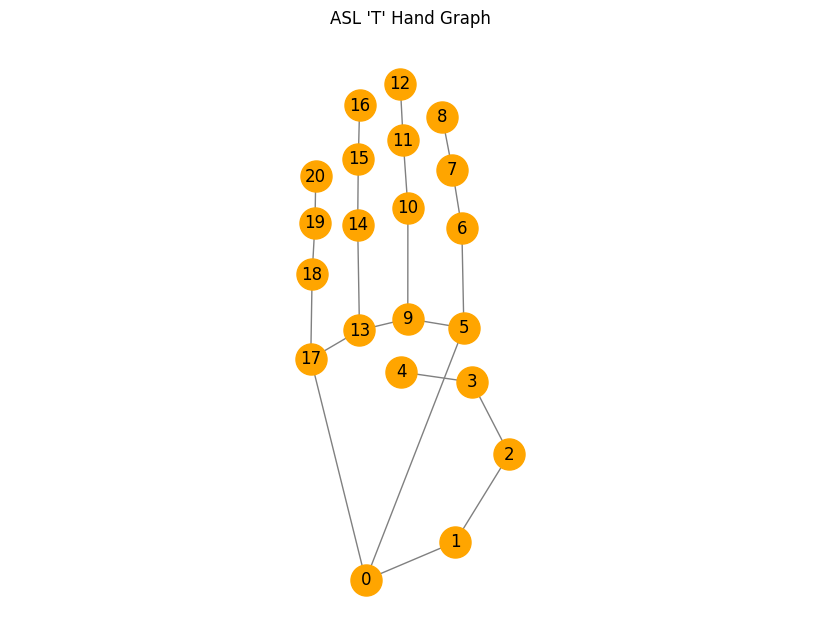

In [44]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

G = to_networkx(graph_for_T, to_undirected=True)
pos = {i: (graph_for_T.x[i][0].item(), graph_for_T.x[i][1].item()) for i in range(graph_for_T.num_nodes)}

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='orange', edge_color='gray', node_size=500)
plt.title("ASL 'T' Hand Graph")
plt.axis('equal')
plt.show()

In [123]:
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn
import torch.nn.functional as F

class HandGNN(torch.nn.Module):
    def __init__(self, num_classes, dropout_rate=0.2, device='cpu'):
        super().__init__()
        self.conv1 = GCNConv(in_channels=3, out_channels=16, cached=False, improved=True)
        self.conv2 = GCNConv(in_channels=16, out_channels=32, cached=False, improved=True)
        
        self.lin = torch.nn.Linear(32, num_classes)
        self.drop = nn.Dropout(dropout_rate)

        self.train_loss_history = []
        self.val_loss_history = []

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = F.relu(self.drop(self.lin(x)))
        
        return x 
    
    def fit(self, train_loader, val_loader, epochs: int = 50, lr: float = 1e-3):
        crit = nn.CrossEntropyLoss(reduction = 'sum')
        optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        for epoch in range(1, epochs+1):

            n_train = 0
            num_correct_train = 0
            n_val = 0
            num_correct_val = 0

            training_loss = 0
            val_loss = 0
            
            self.train()
            for data in tqdm(train_loader):
                #print(data.batch)
                optimizer.zero_grad()
                preds = self.forward(data.x, data.edge_index, data.batch)
                pred_signs = preds.argmax(dim=1) == data.y.long()
                num_correct_train += pred_signs.sum()
                loss = crit(preds, data.y.long())
                training_loss += loss.item() #/ data.num_graphs
                n_train += data.num_graphs
                loss.backward()
                optimizer.step()
            
            self.eval()
            with torch.no_grad():
                for data in tqdm(val_loader):
                    
                    preds = self.forward(data.x, data.edge_index, data.batch)
                    pred_signs = preds.argmax(dim=1) == data.y.long()
                    num_correct_val += pred_signs.sum()
                    val_loss += crit(preds, data.y.long()).item() #/ data.num_graphs
                    n_val += data.num_graphs
                
            self.train_loss_history.append(training_loss/n_train)
            self.val_loss_history.append(val_loss/n_val)
            print(f'Epoch {epoch} Loss- Train: {training_loss/n_train}, Val: {val_loss/n_val}, Accuracy- Train: {num_correct_train/n_train}, Val: {num_correct_val/n_val}')




In [ ]:
data_list = torch.load('valid_ASL_data.pt')
train_data, val_data, test_data = data_split(data_list, train_prop = 0.8, val_prop = 0.1, seed = 1)

train_loader = torch_geometric.loader.DataLoader(train_data, batch_size = 32, shuffle = True)
val_loader = torch_geometric.loader.DataLoader(val_data, batch_size = 128, shuffle = True)
test_loader = torch_geometric.loader.DataLoader(test_data, batch_size = 128, shuffle = True)


In [90]:
type(train_loader)
len(data_list)

62495

In [124]:
net = HandGNN(num_classes=26)
net.fit(train_loader, val_loader, lr = 1e-3)


100%|██████████| 49/49 [00:00<00:00, 210.82it/s]


Epoch 1 Loss- Train: 3.2504755518075723, Val: 3.228335390625, Accuracy- Train: 0.05712457001209259, Val: 0.08879999816417694


100%|██████████| 49/49 [00:00<00:00, 290.18it/s]


Epoch 2 Loss- Train: 3.224264595220352, Val: 3.21605646484375, Accuracy- Train: 0.07604608684778214, Val: 0.08912000060081482


100%|██████████| 49/49 [00:00<00:00, 264.34it/s]


Epoch 3 Loss- Train: 3.216756687916625, Val: 3.2088313330078124, Accuracy- Train: 0.07810624688863754, Val: 0.08991999924182892


100%|██████████| 49/49 [00:00<00:00, 265.25it/s]


Epoch 4 Loss- Train: 3.2099590913440066, Val: 3.20128576171875, Accuracy- Train: 0.08098647743463516, Val: 0.09391999989748001


100%|██████████| 49/49 [00:00<00:00, 291.69it/s]


Epoch 5 Loss- Train: 3.2059046552032266, Val: 3.1982830029296876, Accuracy- Train: 0.08356668800115585, Val: 0.09440000355243683


100%|██████████| 49/49 [00:00<00:00, 272.94it/s]


Epoch 6 Loss- Train: 3.2014355334065154, Val: 3.1928322998046874, Accuracy- Train: 0.08446675539016724, Val: 0.09391999989748001


100%|██████████| 49/49 [00:00<00:00, 282.94it/s]


Epoch 7 Loss- Train: 3.200245059674354, Val: 3.1938511669921876, Accuracy- Train: 0.08274661749601364, Val: 0.09663999825716019


100%|██████████| 49/49 [00:00<00:00, 294.46it/s]


Epoch 8 Loss- Train: 3.196011536178021, Val: 3.18604818359375, Accuracy- Train: 0.08446675539016724, Val: 0.09551999717950821


100%|██████████| 49/49 [00:00<00:00, 313.10it/s]


Epoch 9 Loss- Train: 3.1923155302009123, Val: 3.183528701171875, Accuracy- Train: 0.08546683937311172, Val: 0.09728000313043594


100%|██████████| 49/49 [00:00<00:00, 295.81it/s]


Epoch 10 Loss- Train: 3.1921279467585677, Val: 3.18216931640625, Accuracy- Train: 0.0840667262673378, Val: 0.09935999661684036


100%|██████████| 49/49 [00:00<00:00, 300.73it/s]


Epoch 11 Loss- Train: 3.1912375587550668, Val: 3.1804811328125, Accuracy- Train: 0.08462677150964737, Val: 0.09920000284910202


100%|██████████| 49/49 [00:00<00:00, 210.17it/s]


Epoch 12 Loss- Train: 3.1865575726923634, Val: 3.1778710546875, Accuracy- Train: 0.08646691590547562, Val: 0.09728000313043594


100%|██████████| 49/49 [00:00<00:00, 286.76it/s]


Epoch 13 Loss- Train: 3.1868851470397903, Val: 3.177512724609375, Accuracy- Train: 0.08714697510004044, Val: 0.09967999905347824


100%|██████████| 49/49 [00:00<00:00, 277.32it/s]


Epoch 14 Loss- Train: 3.1837701172587947, Val: 3.176558603515625, Accuracy- Train: 0.08754700422286987, Val: 0.10208000242710114


100%|██████████| 49/49 [00:00<00:00, 282.54it/s]


Epoch 15 Loss- Train: 3.182634008227372, Val: 3.176744541015625, Accuracy- Train: 0.08786702901124954, Val: 0.09775999933481216


100%|██████████| 49/49 [00:00<00:00, 257.66it/s]


Epoch 16 Loss- Train: 3.181731818361143, Val: 3.1715321875, Accuracy- Train: 0.08796703815460205, Val: 0.09647999703884125


100%|██████████| 49/49 [00:00<00:00, 292.85it/s]


Epoch 17 Loss- Train: 3.1807902366106524, Val: 3.1675115576171873, Accuracy- Train: 0.089427150785923, Val: 0.09679999947547913


100%|██████████| 49/49 [00:00<00:00, 299.38it/s]


Epoch 18 Loss- Train: 3.1800838921087076, Val: 3.1660577490234374, Accuracy- Train: 0.08830706775188446, Val: 0.0987199991941452


100%|██████████| 49/49 [00:00<00:00, 321.75it/s]


Epoch 19 Loss- Train: 3.177688509972155, Val: 3.1674278564453124, Accuracy- Train: 0.08996719866991043, Val: 0.10175999999046326


100%|██████████| 49/49 [00:00<00:00, 272.59it/s]


Epoch 20 Loss- Train: 3.1783312029891593, Val: 3.1656652490234376, Accuracy- Train: 0.08938714861869812, Val: 0.1011200025677681


100%|██████████| 49/49 [00:00<00:00, 228.55it/s]


Epoch 21 Loss- Train: 3.175578577841403, Val: 3.165659921875, Accuracy- Train: 0.09074725955724716, Val: 0.10175999999046326


100%|██████████| 49/49 [00:00<00:00, 283.61it/s]


Epoch 22 Loss- Train: 3.176515743497639, Val: 3.169294482421875, Accuracy- Train: 0.08992719650268555, Val: 0.10480000078678131


100%|██████████| 49/49 [00:00<00:00, 225.61it/s]


Epoch 23 Loss- Train: 3.1749580399934194, Val: 3.16206439453125, Accuracy- Train: 0.0902872234582901, Val: 0.10255999863147736


100%|██████████| 49/49 [00:00<00:00, 280.21it/s]


Epoch 24 Loss- Train: 3.1740529937585436, Val: 3.161971279296875, Accuracy- Train: 0.09116729348897934, Val: 0.09888000041246414


100%|██████████| 49/49 [00:00<00:00, 268.20it/s]


Epoch 25 Loss- Train: 3.174251970171652, Val: 3.1588620458984376, Accuracy- Train: 0.08974718302488327, Val: 0.10143999755382538


100%|██████████| 49/49 [00:00<00:00, 208.43it/s]


Epoch 26 Loss- Train: 3.1724859356393775, Val: 3.1584040234375, Accuracy- Train: 0.09058724343776703, Val: 0.10400000214576721


100%|██████████| 49/49 [00:00<00:00, 264.19it/s]


Epoch 27 Loss- Train: 3.1731184487038018, Val: 3.1608942578125, Accuracy- Train: 0.08982718735933304, Val: 0.10416000336408615


100%|██████████| 49/49 [00:00<00:00, 221.75it/s]


Epoch 28 Loss- Train: 3.170911486639634, Val: 3.1568356689453125, Accuracy- Train: 0.09182734787464142, Val: 0.10304000228643417


100%|██████████| 49/49 [00:00<00:00, 209.65it/s]


Epoch 29 Loss- Train: 3.1723706033842327, Val: 3.162047060546875, Accuracy- Train: 0.09120729565620422, Val: 0.10367999970912933


100%|██████████| 49/49 [00:00<00:00, 288.22it/s]


Epoch 30 Loss- Train: 3.169984864124213, Val: 3.155553251953125, Accuracy- Train: 0.09196735918521881, Val: 0.10543999820947647


100%|██████████| 49/49 [00:00<00:00, 244.77it/s]


Epoch 31 Loss- Train: 3.1696091822904915, Val: 3.1572161572265625, Accuracy- Train: 0.0928674265742302, Val: 0.10576000064611435


100%|██████████| 49/49 [00:00<00:00, 242.74it/s]


Epoch 32 Loss- Train: 3.1671080886483125, Val: 3.159958681640625, Accuracy- Train: 0.09264741092920303, Val: 0.10416000336408615


100%|██████████| 49/49 [00:00<00:00, 245.83it/s]


Epoch 33 Loss- Train: 3.169663804122396, Val: 3.1570011083984375, Accuracy- Train: 0.09150732308626175, Val: 0.10016000270843506


100%|██████████| 49/49 [00:00<00:00, 231.81it/s]


Epoch 34 Loss- Train: 3.168379732661938, Val: 3.159089248046875, Accuracy- Train: 0.09400752186775208, Val: 0.10688000172376633


100%|██████████| 49/49 [00:00<00:00, 233.54it/s]


Epoch 35 Loss- Train: 3.1678493818537468, Val: 3.1527249267578124, Accuracy- Train: 0.09172733873128891, Val: 0.1088000014424324


100%|██████████| 49/49 [00:00<00:00, 248.37it/s]


Epoch 36 Loss- Train: 3.1654359074495004, Val: 3.1537701806640626, Accuracy- Train: 0.09350748360157013, Val: 0.11104000359773636


100%|██████████| 49/49 [00:00<00:00, 255.10it/s]


Epoch 37 Loss- Train: 3.1675117062953904, Val: 3.154637880859375, Accuracy- Train: 0.09372749924659729, Val: 0.10608000308275223


100%|██████████| 49/49 [00:00<00:00, 243.37it/s]


Epoch 38 Loss- Train: 3.1668416580321055, Val: 3.1609938671875, Accuracy- Train: 0.09294743835926056, Val: 0.10335999727249146


100%|██████████| 49/49 [00:00<00:00, 221.40it/s]


Epoch 39 Loss- Train: 3.16659608548408, Val: 3.1507204443359376, Accuracy- Train: 0.09462756663560867, Val: 0.10864000022411346


100%|██████████| 49/49 [00:00<00:00, 250.46it/s]


Epoch 40 Loss- Train: 3.1662375728400556, Val: 3.14933677734375, Accuracy- Train: 0.09334746748209, Val: 0.10847999900579453


100%|██████████| 49/49 [00:00<00:00, 248.91it/s]


Epoch 41 Loss- Train: 3.1647997409098148, Val: 3.1539945751953127, Accuracy- Train: 0.09442755579948425, Val: 0.10911999642848969


100%|██████████| 49/49 [00:00<00:00, 181.59it/s]


Epoch 42 Loss- Train: 3.1634927360198337, Val: 3.1507381103515626, Accuracy- Train: 0.09484758973121643, Val: 0.11104000359773636


100%|██████████| 49/49 [00:00<00:00, 242.71it/s]


Epoch 43 Loss- Train: 3.1643477781780893, Val: 3.153484638671875, Accuracy- Train: 0.0947875827550888, Val: 0.11072000116109848


100%|██████████| 49/49 [00:00<00:00, 255.36it/s]


Epoch 44 Loss- Train: 3.164456797901254, Val: 3.1484168310546874, Accuracy- Train: 0.09352748095989227, Val: 0.1120000034570694


100%|██████████| 49/49 [00:00<00:00, 245.71it/s]


Epoch 45 Loss- Train: 3.164546414903378, Val: 3.1447794677734375, Accuracy- Train: 0.0940675288438797, Val: 0.1111999973654747


100%|██████████| 49/49 [00:00<00:00, 225.88it/s]


Epoch 46 Loss- Train: 3.162439855005905, Val: 3.147451044921875, Accuracy- Train: 0.09562765061855316, Val: 0.10831999778747559


100%|██████████| 49/49 [00:00<00:00, 246.99it/s]


Epoch 47 Loss- Train: 3.1616814921060383, Val: 3.15088064453125, Accuracy- Train: 0.09638771414756775, Val: 0.11007999628782272


100%|██████████| 49/49 [00:00<00:00, 233.16it/s]


Epoch 48 Loss- Train: 3.1626142653210354, Val: 3.1470843017578125, Accuracy- Train: 0.09462756663560867, Val: 0.11264000087976456


100%|██████████| 49/49 [00:00<00:00, 234.33it/s]


Epoch 49 Loss- Train: 3.1592245618480046, Val: 3.1471414794921877, Accuracy- Train: 0.09586767107248306, Val: 0.1136000007390976


100%|██████████| 49/49 [00:00<00:00, 221.85it/s]

Epoch 50 Loss- Train: 3.1600286879151502, Val: 3.141912421875, Accuracy- Train: 0.0962677001953125, Val: 0.11007999628782272
